# Top overlapping annotations by weighted sum for saur cohort

In [ ]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [ ]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


<Axes: >

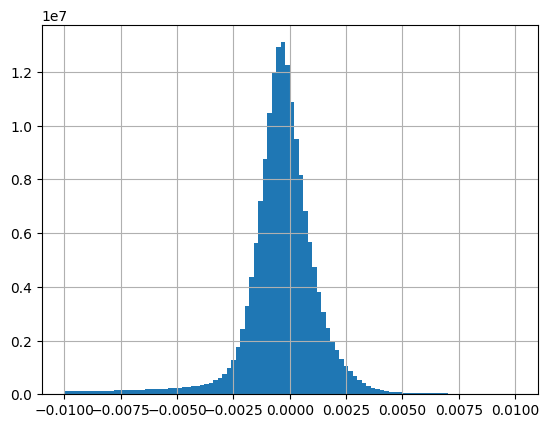

In [3]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [4]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [5]:
len(bedDf.tokens.unique())

3894

In [6]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.012133979502852287)

In [7]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
13703,1,75447,75454,TATACTTT,0.013623,ALF22G140,8
13723,1,75557,75561,AATGA,0.014487,ALF22G140,5
13725,1,75567,75572,CCTGAG,0.015546,ALF22G140,6
13753,1,75724,75731,CTGCACCC,0.018303,ALF22G140,8
13785,1,75898,75902,GAGCA,0.018827,ALF22G140,5
...,...,...,...,...,...,...,...
176698433,5,50635,50641,AATGTTT,0.016897,AH21C044,7
176698449,5,50725,50728,ACTG,0.020198,AH21C044,4
176698513,5,51074,51079,GGCGCG,0.015019,AH21C044,6
176698639,5,51802,51807,AAATAT,0.013009,AH21C044,6


In [8]:
len(highscoreDf.tokens.unique())

1991

In [9]:
highscoreDf.shape

(286987, 7)

<Axes: >

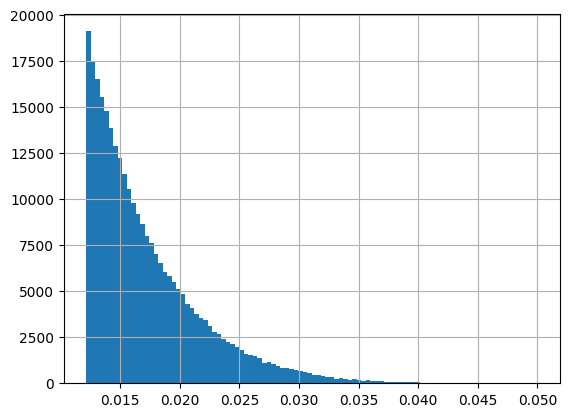

In [10]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [11]:
highscoreDf.token_length.value_counts()

token_length
6     104579
5      75597
7      51246
4      33151
8      16706
3       2680
9       1348
10       798
2        738
13        73
1         68
11         3
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

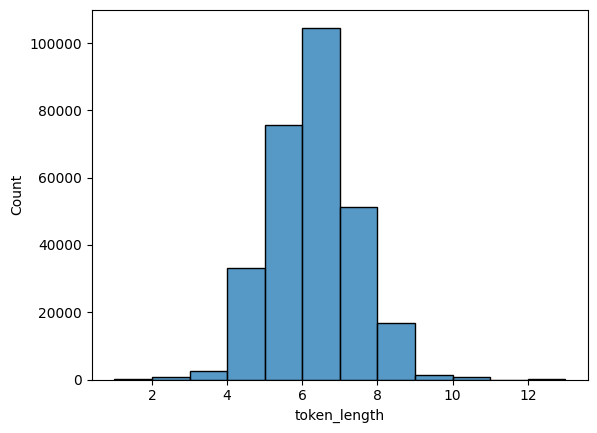

In [12]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read core genes

In [14]:
import os
from pathlib import Path

import pandas as pd


coreGenesPath = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 's_aureus_panaroo_strict', 'core_genes.csv')
coreGenesDf = pd.read_csv(coreGenesPath)
coreGenesDf['Gene'] = coreGenesDf.Gene.str.lower()
coreGenesDf

,Gene,Occurrences
0,hslo,557
1,metg,557
2,spovg,557
3,holb,557
4,rsma,557
...,...,...
1991,group_1,557
1992,tmcal,557
1993,capn,557
1994,rfab~~~cap8l,557


## Read bed files containing overlapping tokens and attribution scores

In [15]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    coreDf = df[df.gene.isin(coreGenesDf.Gene)]
    annotationOverlappingDfList.append(coreDf)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf

 13%|█▎        | 66/515 [01:30<09:37,  1.29s/it]/tmp/ipykernel_67091/4256423940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 24%|██▎       | 122/515 [02:48<07:25,  1.13s/it]/tmp/ipykernel_67091/4256423940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 33%|███▎      | 172/515 [03:58<07:26,  1.30s/it]/tmp/ipykernel_67091/4256423940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
 

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,3,1,138,145,AAAGTAAA,0.009005,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
1,4,1,146,151,AGATAT,-0.010377,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
2,6,1,156,160,GTTGA,-0.016608,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
3,8,1,164,169,TTTAGG,-0.011910,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
4,9,1,170,175,TGTAGA,0.002626,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
78590820,337189,5,204802,204807,AAATCA,-0.001922,CDS,KKIOAG_10520,Folylpolyglutamate synthase/Dihydropteroate synthase,folc,"ID=KKIOAG_10520;Name=Folylpolyglutamate synthase/Dihydropteroate synthase;locus_tag=KKIOAG_10520;product=Folylpolyglutamate synthase/Dihydropteroate synthase;Dbxref=COG:COG0285,COG:H,SO:0001217,UniRef:UniRef50_W8TSW2,UniRef:UniRef90_W8TSW2;gene=folC",AH21K020
78590821,337190,5,204808,204813,AAATTA,-0.000222,CDS,KKIOAG_10520,Folylpolyglutamate synthase/Dihydropteroate synthase,folc,"ID=KKIOAG_10520;Name=Folylpolyglutamate synthase/Dihydropteroate synthase;locus_tag=KKIOAG_10520;product=Folylpolyglutamate synthase/Dihydropteroate synthase;Dbxref=COG:COG0285,COG:H,SO:0001217,UniRef:UniRef50_W8TSW2,UniRef:UniRef90_W8TSW2;gene=folC",AH21K020
78590822,337191,5,204814,204819,GACTTC,-0.000392,CDS,KKIOAG_10520,Folylpolyglutamate synthase/Dihydropteroate synthase,folc,"ID=KKIOAG_10520;Name=Folylpolyglutamate synthase/Dihydropteroate synthase;locus_tag=KKIOAG_10520;product=Folylpolyglutamate synthase/Dihydropteroate synthase;Dbxref=COG:COG0285,COG:H,SO:0001217,UniRef:UniRef50_W8TSW2,UniRef:UniRef90_W8TSW2;gene=folC",AH21K020
78590823,337192,5,204820,204824,GAAGC,-0.000976,CDS,KKIOAG_10520,Folylpolyglutamate synthase/Dihydropteroate synthase,folc,"ID=KKIOAG_10520;Name=Folylpolyglutamate synthase/Dihydropteroate synthase;locus_tag=KKIOAG_10520;product=Folylpolyglutamate synthase/Dihydropteroate synthase;Dbxref=COG:COG0285,COG:H,SO:0001217,UniRef:UniRef50_W8TSW2,UniRef:UniRef90_W8TSW2;gene=folC",AH21K020


In [16]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrOverlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        amrOverlappingDfList.append(tubeidOverlappingDf)

amrOverlappingDf = pd.concat(amrOverlappingDfList, ignore_index=True)
amrOverlappingDf

100%|██████████| 557/557 [00:10<00:00, 52.09it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,5,115189,115193,CCAAT,0.013918,AH20K063,5,NaN,5,113439,115193,+,blaR1,beta-lactam sensor/signal transducer BlaR1,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,585,585,100.0,91.45,585,WP_001096386.1,beta-lactam sensor/signal transducer BlaR1,NaN,NaN,AH20K063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1607,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1608,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1609,1,464540,464543,TTGA,0.013898,AH21C044,4,NaN,1,464367,465893,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.0,99.21,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH21C044


In [17]:
overlappingDf = pd.concat(
    [
        annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']],
        amrOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'Gene symbol', 'Sequence name', 'tube_code']].rename(columns={'Gene symbol': 'gene', 'Sequence name': 'name'})
    ],
    names=['contig_id', 'start_position', 'end_position', 'tokens', 'gene'],
    ignore_index=False
)
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,138,145,AAAGTAAA,0.009005,acpp,acyl carrier protein,AH20I016
1,1,146,151,AGATAT,-0.010377,acpp,acyl carrier protein,AH20I016
2,1,156,160,GTTGA,-0.016608,acpp,acyl carrier protein,AH20I016
3,1,164,169,TTTAGG,-0.011910,acpp,acyl carrier protein,AH20I016
4,1,170,175,TGTAGA,0.002626,acpp,acyl carrier protein,AH20I016
...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,mepA,multidrug efflux MATE transporter MepA,AH20L076
1607,3,313975,313979,CTTTG,0.014194,mepA,multidrug efflux MATE transporter MepA,AH20L076
1608,3,314026,314030,ACAGT,0.012561,mepA,multidrug efflux MATE transporter MepA,AH20L076
1609,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044


## Get overlapping genes for high-score tokens

In [18]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
1,1,302,309,AAAAATCA,0.012217,acpp,acyl carrier protein,AH20I016
2,1,483,491,AAAGAAAAG,0.018888,rnc,ribonuclease III,AH20I016
3,1,604,608,AATGA,0.015653,rnc,ribonuclease III,AH20I016
4,1,609,615,TTTTAAT,0.018532,rnc,ribonuclease III,AH20I016
...,...,...,...,...,...,...,...,...
199425,3,313975,313979,CTTTG,0.014194,mepA,multidrug efflux MATE transporter MepA,AH20L076
199426,3,314026,314030,ACAGT,0.012561,mepA,multidrug efflux MATE transporter MepA,AH20L076
199427,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044
199428,5,67876,67879,TTGA,0.013503,blaI,penicillinase repressor BlaI,AH21C044


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [19]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_67091/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x744dedfac3a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,aaa,1.831435
1,abgb,6.237819
2,abrb,2.703959
3,acca,1.785996
4,accb,2.941337
...,...,...
1357,zapa,1.286040
1358,znua,9.320601
1359,znub,4.685461
1360,znuc,3.138582


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

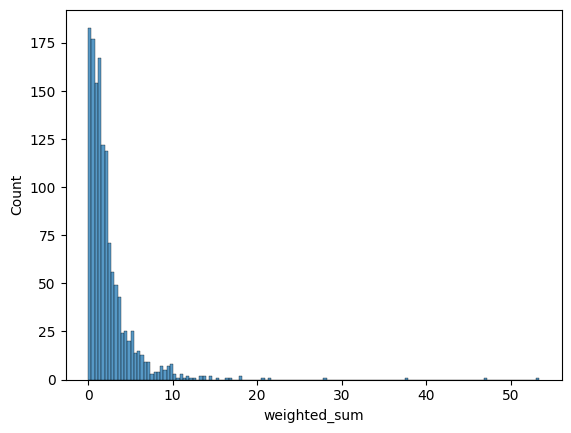

In [20]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [22]:
weightedsumCutoff = geneWeightedsumDf.weighted_sum.mean() + (2 * geneWeightedsumDf.weighted_sum.std())
weightedsumCutoff

np.float64(9.105104250166177)

In [23]:
geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)

,gene,weighted_sum
259,essc,53.386270
359,gltb,46.922011
319,ftsk,37.587255
88,bglg,28.027139
819,ptsg,21.585067
859,qri1,20.626175
782,polc,17.918393
117,ccma,17.915418
1014,sbcc,16.813448
10,acoa,16.322731


## Create gene-type lookup table from amrfinderplus annotations

In [24]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_67091/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [25]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [26]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [27]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [28]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)


geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates(subset=['gene', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type'])

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,essc,type VII secretion system protein EssC%2C FtsK/SpoIIIE family ATPase,53.386270,NaN,NaN,NaN
2,gltb,glutamate synthase large subunit,46.922011,NaN,NaN,NaN
3,ftsk,DNA segregation ATPase FtsK/SpoIIIE or related protein,37.587255,NaN,NaN,NaN
5,bglg,Transcriptional antiterminator,28.027139,NaN,NaN,NaN
7,ptsg,PTS system glucose-specific EIICBA component,21.585067,NaN,NaN,NaN
9,qri1,putative uridylyltransferase MW2097,20.626175,NaN,NaN,NaN
10,polc,PolC-type DNA polymerase III,17.918393,NaN,NaN,NaN
11,ccma,ABC-type multidrug transport system%2C ATPase component,17.915418,NaN,NaN,NaN
13,sbcc,Nuclease SbcCD subunit C,16.813448,NaN,NaN,NaN
14,acoa,TPP-dependent pyruvate or acetoin dehydrogenase subunit alpha,16.322731,NaN,NaN,NaN


## Save all gene hits

In [38]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'saur_top_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [41]:
import pandas as pd

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [42]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [43]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [44]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [45]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_validate.csv'), sep='\t')
mortality7Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality7Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [46]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortality30Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality30Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [47]:
import pandas as pd


mortalityDf = mortality7Df.merge(
    mortality30Df,
    how='inner',
    on=['person_id', 'JOURNEY_ID', 'visit_occurrence_id']
)
# mortalityDf = mortality30Df
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day,death_30_day
0,678487,3312694,3312694,0,0
1,2094045,9199249,9199249,0,0
2,2107813,9410987,9410987,1,1
3,2083212,9039515,9039515,0,0
4,2083212,9039437,602890,0,0
...,...,...,...,...,...
7290,2603535,16709341,16709341,0,0
7291,2603535,16651755,16651755,0,0
7292,2603535,16588204,16588204,0,0
7293,2098616,16872774,16872774,0,0


## Create annotations data matrix

In [48]:
geneWeightedsumDf

,gene,weighted_sum
0,aaa,1.831435
1,abgb,6.237819
2,abrb,2.703959
3,acca,1.785996
4,accb,2.941337
...,...,...
1357,zapa,1.286040
1358,znua,9.320601
1359,znub,4.685461
1360,znuc,3.138582


In [55]:
signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)['gene'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
50,1,104059,104064,GATGTG,0.027761,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
51,1,104122,104128,AAAATGG,0.014966,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
52,1,104373,104377,TTTGT,0.016255,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
53,1,104463,104469,CCAACAT,0.020258,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
54,1,104625,104630,AATGAT,0.014629,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
...,...,...,...,...,...,...,...,...
199356,1,358534,358539,TAAAGG,0.013273,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
199357,1,358734,358737,AACC,0.015188,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
199358,1,358845,358851,CTATAAA,0.016098,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
199359,1,358993,358997,CATGA,0.013797,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011


In [56]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,acoa,acob,arac,azor,bglg,ccdc,ccma,coba,deob,...,recj,sbcc,sbcd,sfca,tet(38),typa,uhpt,walk,yqfa,znua
50,AH20I016,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
143,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
443,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199031,ALF22I018,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
199126,AH21E078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
199265,AH19F054,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
199323,AH20B051,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Create datamatrix

In [57]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,acoa,acob,arac,azor,bglg,ccdc,...,recj,sbcc,sbcd,sfca,tet(38),typa,uhpt,walk,yqfa,znua
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
874,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
875,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [58]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,acoa,acob,arac,azor,bglg,ccdc,ccma,coba,...,recj,sbcc,sbcd,sfca,tet(38),typa,uhpt,walk,yqfa,znua
death_30_day,0.563012,1.000000,0.004890,0.004890,-0.005202,0.006932,-0.006390,0.032887,-0.018190,-0.040223,...,-0.019607,0.032887,-0.003668,0.004890,0.020721,-0.050967,0.004890,-0.005202,-0.040223,0.014213
death_7_day,1.000000,0.563012,0.041401,0.041401,0.007004,0.058685,-0.007415,0.032522,0.016568,-0.022646,...,-0.036685,0.032522,-0.022646,-0.020244,0.046126,-0.028695,-0.020244,-0.032119,-0.022646,-0.026826
pepf,0.093192,0.082457,-0.006893,-0.006893,-0.010936,-0.009770,-0.013432,-0.007711,-0.018492,-0.007711,...,-0.012490,-0.007711,-0.007711,-0.006893,-0.010936,-0.009770,-0.006893,-0.010936,-0.007711,-0.009134
ptsg,0.065612,0.047911,-0.010341,-0.010341,-0.016406,-0.014657,-0.020152,-0.011568,-0.027743,-0.011568,...,-0.018739,-0.011568,-0.011568,-0.010341,-0.016406,-0.014657,-0.010341,-0.016406,-0.011568,-0.013703
era,0.003617,0.039056,-0.007629,-0.007629,-0.012104,-0.010814,-0.014867,-0.008534,-0.020467,-0.008534,...,-0.013825,-0.008534,-0.008534,-0.007629,-0.012104,-0.010814,-0.007629,-0.012104,-0.008534,-0.010109
iles,0.058685,0.035881,-0.006495,-0.006495,-0.010304,-0.009206,-0.012657,-0.007265,-0.017424,-0.007265,...,-0.011769,-0.007265,-0.007265,-0.006495,-0.010304,-0.009206,-0.006495,-0.010304,-0.007265,-0.008606
gltb,0.058685,0.035881,-0.006495,-0.006495,-0.010304,-0.009206,-0.012657,-0.007265,-0.017424,-0.007265,...,-0.011769,-0.007265,-0.007265,-0.006495,-0.010304,-0.009206,-0.006495,-0.010304,-0.007265,-0.008606
sbcc,0.032522,0.032887,-0.005126,-0.005126,-0.008132,-0.007265,-0.009989,-0.005734,-0.013752,-0.005734,...,-0.009288,1.000000,-0.005734,-0.005126,-0.008132,-0.007265,-0.005126,-0.008132,-0.005734,-0.006792
ccdc,0.032522,0.032887,-0.005126,-0.005126,-0.008132,-0.007265,-0.009989,1.000000,-0.013752,-0.005734,...,-0.009288,-0.005734,-0.005734,-0.005126,-0.008132,-0.007265,-0.005126,-0.008132,-0.005734,-0.006792
leuc,-0.014298,0.032304,-0.003236,-0.003236,-0.005135,-0.004587,-0.006307,-0.003620,-0.008682,-0.003620,...,-0.005864,-0.003620,-0.003620,-0.003236,-0.005135,-0.004587,-0.003236,-0.005135,-0.003620,-0.004288


### Plot correlations as a heatmap

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'acoa'),
 Text(0, 3.5, 'acob'),
 Text(0, 4.5, 'arac'),
 Text(0, 5.5, 'azor'),
 Text(0, 6.5, 'bglg'),
 Text(0, 7.5, 'ccdc'),
 Text(0, 8.5, 'ccma'),
 Text(0, 9.5, 'coba'),
 Text(0, 10.5, 'deob'),
 Text(0, 11.5, 'ecsb'),
 Text(0, 12.5, 'era'),
 Text(0, 13.5, 'essc'),
 Text(0, 14.5, 'fadb'),
 Text(0, 15.5, 'fdhf'),
 Text(0, 16.5, 'fepd'),
 Text(0, 17.5, 'ftsk'),
 Text(0, 18.5, 'ftsw'),
 Text(0, 19.5, 'fumc'),
 Text(0, 20.5, 'gap'),
 Text(0, 21.5, 'gltb'),
 Text(0, 22.5, 'hara'),
 Text(0, 23.5, 'iles'),
 Text(0, 24.5, 'leuc'),
 Text(0, 25.5, 'lysr'),
 Text(0, 26.5, 'mdlb'),
 Text(0, 27.5, 'mete'),
 Text(0, 28.5, 'miab'),
 Text(0, 29.5, 'ndh'),
 Text(0, 30.5, 'nirb'),
 Text(0, 31.5, 'pepf'),
 Text(0, 32.5, 'polc'),
 Text(0, 33.5, 'pote'),
 Text(0, 34.5, 'pros'),
 Text(0, 35.5, 'ptsg'),
 Text(0, 36.5, 'ptsn'),
 Text(0, 37.5, 'pyca'),
 Text(0, 38.5, 'qri1'),
 Text(0, 39.5, 'recj'),
 Text(0, 40.5, 'sbcc'),
 Text(0, 41.5,

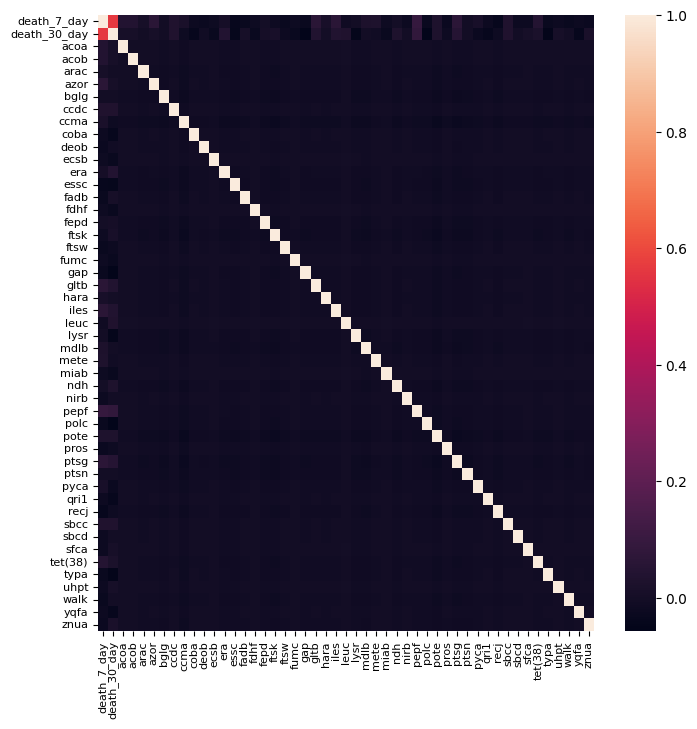

In [75]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr()

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf)

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap (Log scale)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'acoa'),
 Text(0, 3.5, 'acob'),
 Text(0, 4.5, 'arac'),
 Text(0, 5.5, 'azor'),
 Text(0, 6.5, 'bglg'),
 Text(0, 7.5, 'ccdc'),
 Text(0, 8.5, 'ccma'),
 Text(0, 9.5, 'coba'),
 Text(0, 10.5, 'deob'),
 Text(0, 11.5, 'ecsb'),
 Text(0, 12.5, 'era'),
 Text(0, 13.5, 'essc'),
 Text(0, 14.5, 'fadb'),
 Text(0, 15.5, 'fdhf'),
 Text(0, 16.5, 'fepd'),
 Text(0, 17.5, 'ftsk'),
 Text(0, 18.5, 'ftsw'),
 Text(0, 19.5, 'fumc'),
 Text(0, 20.5, 'gap'),
 Text(0, 21.5, 'gltb'),
 Text(0, 22.5, 'hara'),
 Text(0, 23.5, 'iles'),
 Text(0, 24.5, 'leuc'),
 Text(0, 25.5, 'lysr'),
 Text(0, 26.5, 'mdlb'),
 Text(0, 27.5, 'mete'),
 Text(0, 28.5, 'miab'),
 Text(0, 29.5, 'ndh'),
 Text(0, 30.5, 'nirb'),
 Text(0, 31.5, 'pepf'),
 Text(0, 32.5, 'polc'),
 Text(0, 33.5, 'pote'),
 Text(0, 34.5, 'pros'),
 Text(0, 35.5, 'ptsg'),
 Text(0, 36.5, 'ptsn'),
 Text(0, 37.5, 'pyca'),
 Text(0, 38.5, 'qri1'),
 Text(0, 39.5, 'recj'),
 Text(0, 40.5, 'sbcc'),
 Text(0, 41.5,

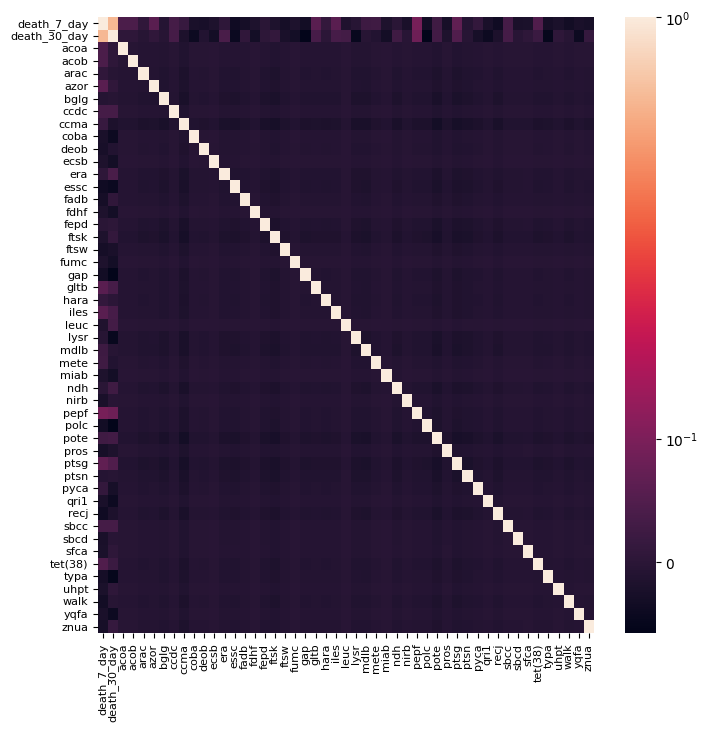

In [76]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr()

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap (Log scale - Sorted)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'pepf'),
 Text(0, 3.5, 'ptsg'),
 Text(0, 4.5, 'azor'),
 Text(0, 5.5, 'gltb'),
 Text(0, 6.5, 'iles'),
 Text(0, 7.5, 'tet(38)'),
 Text(0, 8.5, 'acob'),
 Text(0, 9.5, 'acoa'),
 Text(0, 10.5, 'ccdc'),
 Text(0, 11.5, 'sbcc'),
 Text(0, 12.5, 'pote'),
 Text(0, 13.5, 'mete'),
 Text(0, 14.5, 'mdlb'),
 Text(0, 15.5, 'ccma'),
 Text(0, 16.5, 'pyca'),
 Text(0, 17.5, 'hara'),
 Text(0, 18.5, 'arac'),
 Text(0, 19.5, 'era'),
 Text(0, 20.5, 'fepd'),
 Text(0, 21.5, 'ndh'),
 Text(0, 22.5, 'lysr'),
 Text(0, 23.5, 'bglg'),
 Text(0, 24.5, 'ptsn'),
 Text(0, 25.5, 'leuc'),
 Text(0, 26.5, 'miab'),
 Text(0, 27.5, 'fumc'),
 Text(0, 28.5, 'fdhf'),
 Text(0, 29.5, 'ecsb'),
 Text(0, 30.5, 'ftsk'),
 Text(0, 31.5, 'sfca'),
 Text(0, 32.5, 'uhpt'),
 Text(0, 33.5, 'qri1'),
 Text(0, 34.5, 'yqfa'),
 Text(0, 35.5, 'nirb'),
 Text(0, 36.5, 'coba'),
 Text(0, 37.5, 'sbcd'),
 Text(0, 38.5, 'deob'),
 Text(0, 39.5, 'znua'),
 Text(0, 40.5, 'pros'),
 Text(0, 4

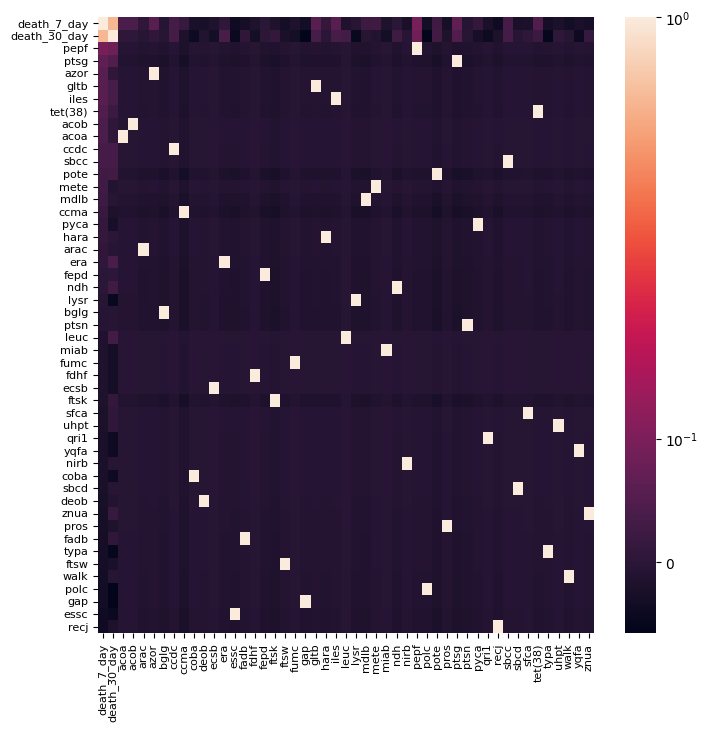

In [79]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_7_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap for 7 day mortality target (Log scale - Sorted)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'pepf'),
 Text(0, 2.5, 'ptsg'),
 Text(0, 3.5, 'azor'),
 Text(0, 4.5, 'gltb'),
 Text(0, 5.5, 'iles'),
 Text(0, 6.5, 'tet(38)'),
 Text(0, 7.5, 'acob'),
 Text(0, 8.5, 'acoa'),
 Text(0, 9.5, 'ccdc'),
 Text(0, 10.5, 'sbcc'),
 Text(0, 11.5, 'pote'),
 Text(0, 12.5, 'mete'),
 Text(0, 13.5, 'mdlb'),
 Text(0, 14.5, 'ccma'),
 Text(0, 15.5, 'pyca'),
 Text(0, 16.5, 'hara'),
 Text(0, 17.5, 'arac'),
 Text(0, 18.5, 'era'),
 Text(0, 19.5, 'fepd'),
 Text(0, 20.5, 'ndh'),
 Text(0, 21.5, 'lysr'),
 Text(0, 22.5, 'bglg'),
 Text(0, 23.5, 'ptsn'),
 Text(0, 24.5, 'leuc'),
 Text(0, 25.5, 'miab'),
 Text(0, 26.5, 'fumc'),
 Text(0, 27.5, 'fdhf'),
 Text(0, 28.5, 'ecsb'),
 Text(0, 29.5, 'ftsk'),
 Text(0, 30.5, 'sfca'),
 Text(0, 31.5, 'uhpt'),
 Text(0, 32.5, 'qri1'),
 Text(0, 33.5, 'yqfa'),
 Text(0, 34.5, 'nirb'),
 Text(0, 35.5, 'coba'),
 Text(0, 36.5, 'sbcd'),
 Text(0, 37.5, 'deob'),
 Text(0, 38.5, 'znua'),
 Text(0, 39.5, 'pros'),
 Text(0, 40.5, 'fadb'),
 Text(0, 41.5, 'ty

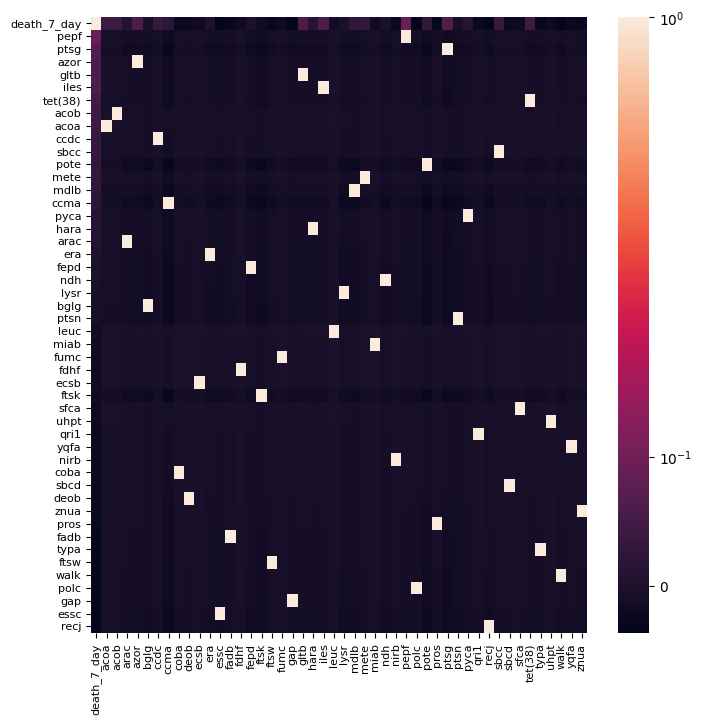

In [81]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day']).corr().sort_values('death_7_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap for 30 day mortality target (Log scale - Sorted)

[Text(0, 0.5, 'death_30_day'),
 Text(0, 1.5, 'pepf'),
 Text(0, 2.5, 'ptsg'),
 Text(0, 3.5, 'era'),
 Text(0, 4.5, 'iles'),
 Text(0, 5.5, 'gltb'),
 Text(0, 6.5, 'sbcc'),
 Text(0, 7.5, 'ccdc'),
 Text(0, 8.5, 'leuc'),
 Text(0, 9.5, 'pote'),
 Text(0, 10.5, 'ndh'),
 Text(0, 11.5, 'tet(38)'),
 Text(0, 12.5, 'znua'),
 Text(0, 13.5, 'ftsk'),
 Text(0, 14.5, 'azor'),
 Text(0, 15.5, 'fadb'),
 Text(0, 16.5, 'acob'),
 Text(0, 17.5, 'uhpt'),
 Text(0, 18.5, 'sfca'),
 Text(0, 19.5, 'acoa'),
 Text(0, 20.5, 'fepd'),
 Text(0, 21.5, 'hara'),
 Text(0, 22.5, 'nirb'),
 Text(0, 23.5, 'sbcd'),
 Text(0, 24.5, 'walk'),
 Text(0, 25.5, 'arac'),
 Text(0, 26.5, 'mdlb'),
 Text(0, 27.5, 'ptsn'),
 Text(0, 28.5, 'bglg'),
 Text(0, 29.5, 'mete'),
 Text(0, 30.5, 'deob'),
 Text(0, 31.5, 'pros'),
 Text(0, 32.5, 'ccma'),
 Text(0, 33.5, 'recj'),
 Text(0, 34.5, 'ftsw'),
 Text(0, 35.5, 'pyca'),
 Text(0, 36.5, 'fumc'),
 Text(0, 37.5, 'ecsb'),
 Text(0, 38.5, 'miab'),
 Text(0, 39.5, 'fdhf'),
 Text(0, 40.5, 'yqfa'),
 Text(0, 41.5, 'q

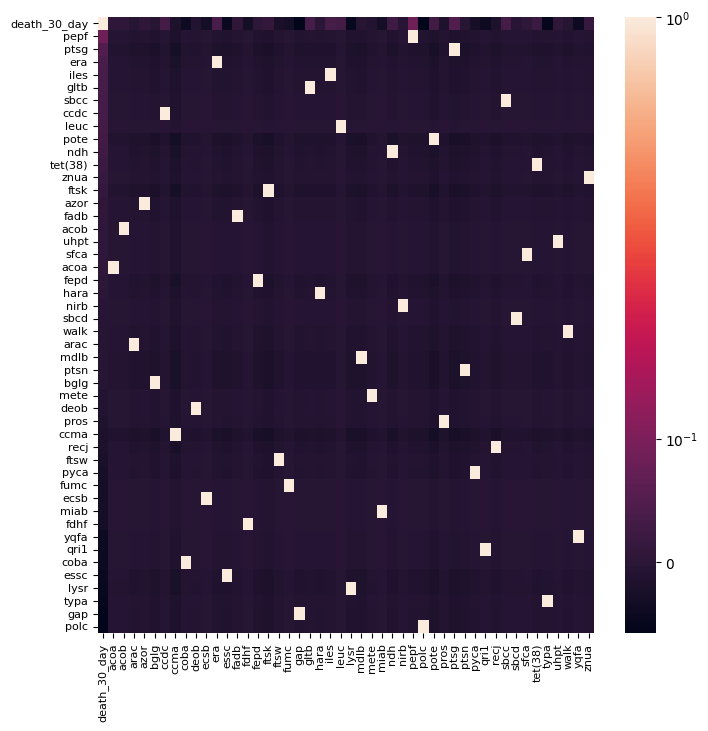

In [82]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day']).corr().sort_values('death_30_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Model using machine learning (7 day mortality)

In [95]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_7_day

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.2784090909090909
Balanced Accuracy:  0.51875
Average Precision:  0.09414399469143994
F1 Score:  0.16993464052287582
ROC AUC:  0.51875


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.9090909090909091
Balanced Accuracy:  0.5
Average Precision:  0.09090909090909091
F1 Score:  0.0
ROC AUC:  0.5


In [99]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
11,essc,-0.517778
37,recj,-0.517778
44,walk,-0.446859
18,gap,-0.408561
30,polc,-0.408561
16,ftsw,-0.368114
20,hara,-0.325287
10,era,-0.325287
12,fadb,-0.325287
32,pros,-0.325287


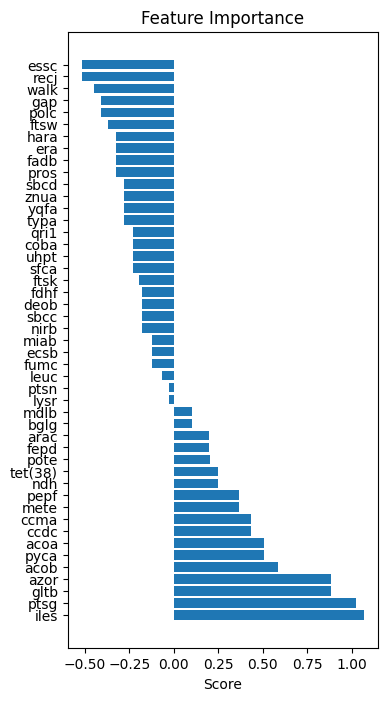

In [100]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(4, 8))

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


### Model using machine learning (30 day mortality)

In [88]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_30_day

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.3068181818181818
Balanced Accuracy:  0.4978795589482612
Average Precision:  0.2548775976323747
F1 Score:  0.39603960396039606
ROC AUC:  0.4978795589482612


In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7443181818181818
Balanced Accuracy:  0.5
Average Precision:  0.2556818181818182
F1 Score:  0.0
ROC AUC:  0.5


In [91]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
30,polc,-0.826941
18,gap,-0.826941
16,ftsw,-0.764727
20,hara,-0.695666
23,lysr,-0.654043
45,yqfa,-0.618230
42,typa,-0.618230
7,coba,-0.530384
36,qri1,-0.530384
11,essc,-0.498342


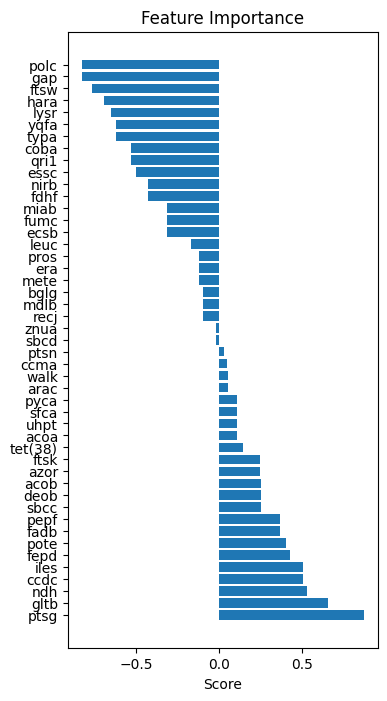

In [94]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(4, 8))

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [101]:
import numpy as np


tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_67091/457035517.py:4: FutureWarning: The provided callable <function sum at 0x744dedfac3a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,AAAAAA,0.031420
1,AAAAAAA,0.874996
2,AAAAAAT,0.242617
3,AAAAAATTA,0.044526
4,AAAAACAA,0.993249
...,...,...
1249,TTTTGTTTT,0.027434
1250,TTTTTAA,0.443443
1251,TTTTTCA,2.804043
1252,TTTTTCT,0.140193


In [102]:
signatureTokensDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
23,1,13080,13084,TTTGT,0.014794,yfho,lipoteichoic acid-specific glycosyltransferase YfhO,AH20I016
30,1,43186,43191,CAATAA,0.015891,rimp,ribosome maturation factor RimP,AH20I016
33,1,44362,44366,CCAGT,0.012659,nusa,Transcription antitermination factor NusA%2C contains S1 and KH domains,AH20I016
37,1,102681,102686,AAACAT,0.013746,cls,cardiolipin synthase,AH20I016
...,...,...,...,...,...,...,...,...
199405,3,312909,312914,TAATTT,0.015043,mepA,multidrug efflux MATE transporter MepA,AH20L076
199410,3,313125,313131,AATGTTT,0.015912,mepA,multidrug efflux MATE transporter MepA,AH20L076
199412,3,313171,313176,CAATTT,0.025049,mepA,multidrug efflux MATE transporter MepA,AH20L076
199415,3,313529,313533,ATGGT,0.019383,mepA,multidrug efflux MATE transporter MepA,AH20L076


In [103]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,...,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
23,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
30,AH20I016,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,AH20I016,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199216,ALF23C174,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
199219,ALF23C174,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
199220,ALF23C174,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
199221,ALF23C174,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [104]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,...,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1764,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1765,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1766,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [105]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,...,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
death_30_day,0.604927,1.000000,0.004232,-0.000995,0.005931,0.005931,0.002557,0.011182,0.002557,0.007655,...,0.000679,-0.000995,-0.018707,0.018931,0.002557,0.000679,-0.002645,-0.002645,0.001990,-0.000995
death_7_day,1.000000,0.604927,0.008891,0.009964,0.009964,0.009964,0.007834,0.013282,0.007834,0.011053,...,0.001282,0.009964,-0.017370,0.022972,0.007834,0.011053,-0.000741,-0.000741,-0.009775,0.009964
GGTCT,0.022972,0.018931,-0.036172,-0.035894,-0.035894,-0.035894,-0.036448,-0.035051,-0.036448,-0.035615,...,-0.035615,-0.035894,-0.035334,1.000000,-0.036448,-0.035615,-0.036172,-0.036172,-0.033011,-0.035894
CAATAA,0.013282,0.011182,-0.038760,-0.038463,-0.038463,-0.038463,-0.039056,1.000000,-0.039056,-0.038163,...,-0.038163,-0.038463,-0.037862,-0.035051,-0.039056,-0.038163,-0.038760,-0.038760,-0.035373,-0.038463
CACCGT,0.011053,0.007655,-0.039384,-0.039082,-0.039082,-0.039082,-0.039684,-0.038163,-0.039684,1.000000,...,-0.038778,-0.039082,-0.038472,-0.035615,-0.039684,-0.038778,-0.039384,-0.039384,-0.035942,-0.039082
AACAC,0.009964,0.005931,-0.039693,-0.039389,1.000000,-0.039389,-0.039996,-0.038463,-0.039996,-0.039082,...,-0.039082,-0.039389,-0.038773,-0.035894,-0.039996,-0.039082,-0.039693,-0.039693,-0.036224,-0.039389
AATGTTT,0.009964,0.005931,-0.039693,-0.039389,-0.039389,1.000000,-0.039996,-0.038463,-0.039996,-0.039082,...,-0.039082,-0.039389,-0.038773,-0.035894,-0.039996,-0.039082,-0.039693,-0.039693,-0.036224,-0.039389
AAAATGT,0.008891,0.004232,1.000000,-0.039693,-0.039693,-0.039693,-0.040305,-0.038760,-0.040305,-0.039384,...,-0.039384,-0.039693,-0.039073,-0.036172,-0.040305,-0.039384,-0.040000,-0.040000,-0.036504,-0.039693
CCAGT,0.008891,0.004232,-0.040000,-0.039693,-0.039693,-0.039693,-0.040305,-0.038760,-0.040305,-0.039384,...,-0.039384,-0.039693,-0.039073,-0.036172,-0.040305,-0.039384,-0.040000,-0.040000,-0.036504,-0.039693
ATGGT,0.007834,0.002557,-0.040305,-0.039996,-0.039996,-0.039996,1.000000,-0.039056,-0.040612,-0.039684,...,-0.039684,-0.039996,-0.039371,-0.036448,-0.040612,-0.039684,-0.040305,-0.040305,-0.036782,-0.039996


### Plot correlations as a heatmap

<Axes: >

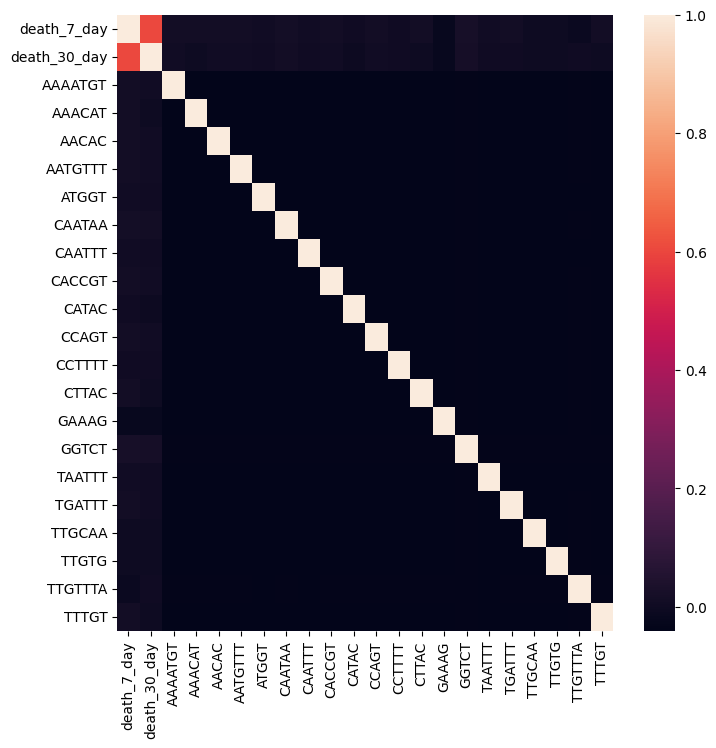

In [106]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

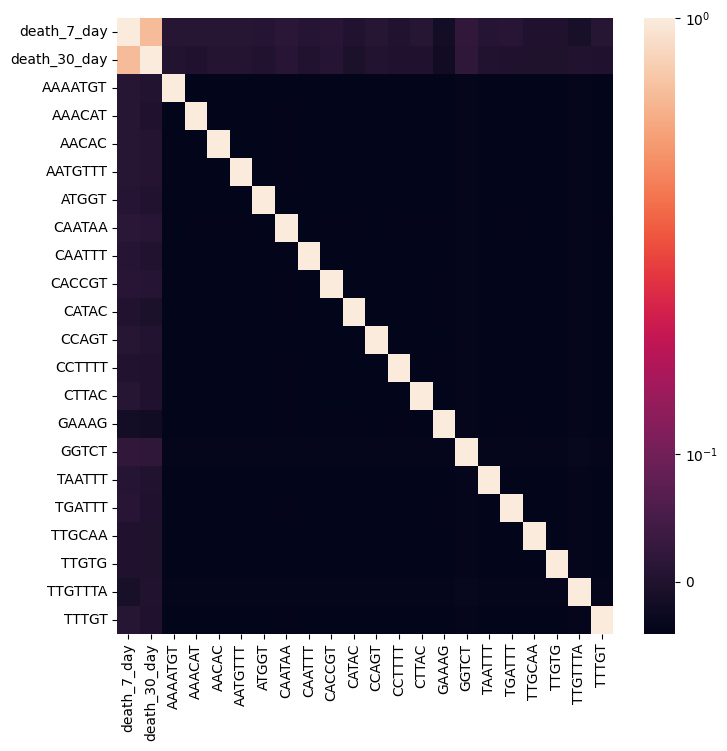

In [107]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

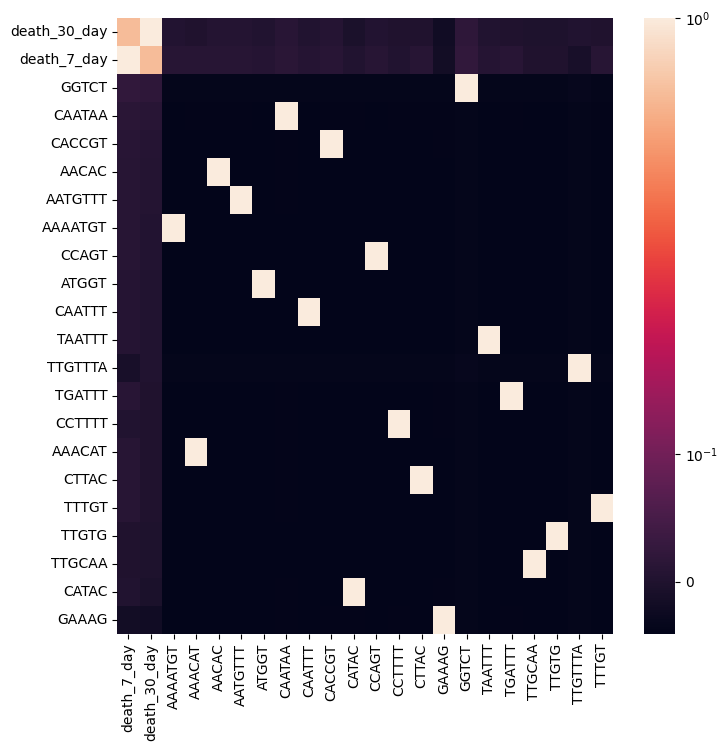

In [108]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day)

In [109]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_7_day

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.6638418079096046
Balanced Accuracy:  0.4184073663568932
Average Precision:  0.09802514378785564
F1 Score:  0.06299212598425197
ROC AUC:  0.4184073663568932


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8954802259887006
Balanced Accuracy:  0.5
Average Precision:  0.10451977401129943
F1 Score:  0.0
ROC AUC:  0.5


In [112]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
18,TTGTTTA,-0.265529
12,GAAAG,-0.125299
5,CAATAA,-0.029048
10,CCTTTT,0.076627
2,AACAC,0.142768
16,TTGCAA,0.160287
6,CAATTT,0.250481
8,CATAC,0.279506
9,CCAGT,0.279506
14,TAATTT,0.343005


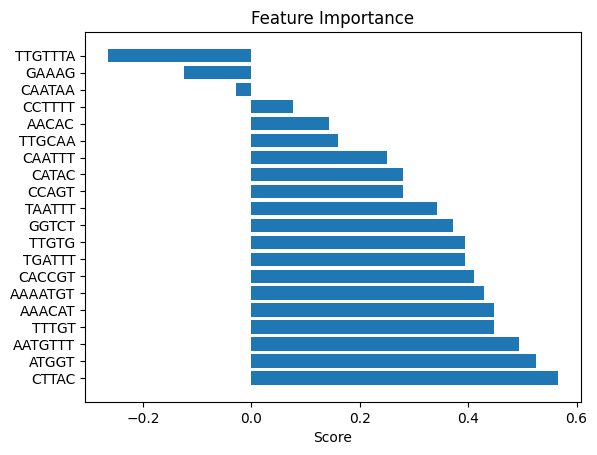

In [113]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

In [124]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'ATGGT'][['gene']].value_counts()[:20]

gene
ecsb    246
sfca    130
leuc    114
gltb    112
accd    101
sers     97
fumc     85
topa     79
bglg     77
polc     74
acef     74
acob     71
rnj1     60
rlmb     57
thra     54
pyca     52
ftsk     49
recx     44
mete     38
fdhf     38
Name: count, dtype: int64

### Model using machine learning (30 day)

In [114]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_30_day

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.5932203389830508
Balanced Accuracy:  0.4233772995487678
Average Precision:  0.23039555124695055
F1 Score:  0.1
ROC AUC:  0.42337729954876785


In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7570621468926554
Balanced Accuracy:  0.5
Average Precision:  0.24293785310734464
F1 Score:  0.0
ROC AUC:  0.5


In [117]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
12,GAAAG,-0.244021
10,CCTTTT,-0.039444
5,CAATAA,-0.005914
0,AAAATGT,0.004053
4,ATGGT,0.018153
19,TTTGT,0.026548
1,AAACAT,0.026548
6,CAATTT,0.045695
15,TGATTT,0.055326
16,TTGCAA,0.073158


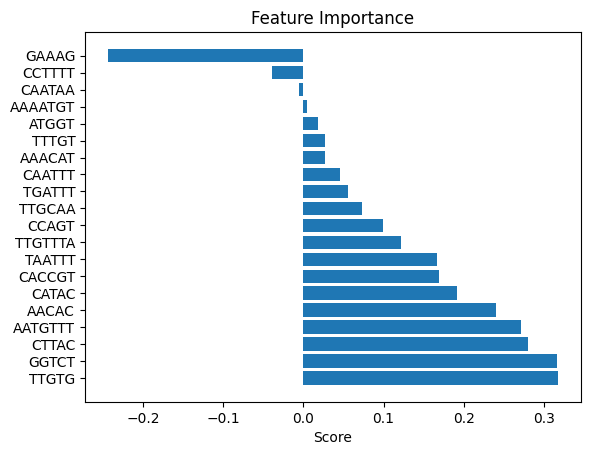

In [118]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

In [125]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'TTGTG'][['gene']].value_counts()[:20]

gene 
leuc     120
gltb      91
metc      78
dppb      68
cysk      62
ptsg      58
thrc      57
metl1     46
ybci      45
mnth      43
tdcb      41
pflb      41
hara      40
znua      38
fadk      38
ygae      37
rsbu      35
accb      33
acyp      29
thrs      28
Name: count, dtype: int64